# BP-AR-HMM

In [1]:
import os
import bnpy
from utility import setup
import numpy as np
import pandas
from matplotlib import pyplot as plt

def show_single_sequence(dataset, seq_id):
    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    for dim in range(12):
        X_seq = dataset.X[start:stop]
        plt.plot(X_seq[:, dim], '-')
#     pylab.xlabel('time')
#     pylab.ylabel('angle')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


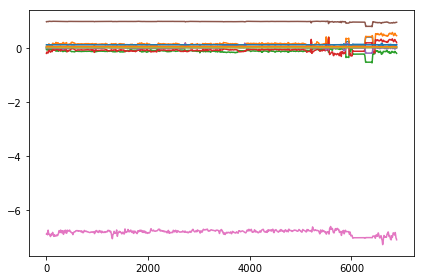

In [2]:
alpha = 0.5
gamma = 5.0
sF = 1.0
K = 20
subjects = ["005", "006", "007", "009", "010", "013","014",
            "015", "016", "018", "021", "022", "024", "026"]
data, features, boost = setup(subjects, zscore=False, convolve=True)
X_list = []
Xprev_list = []
TrueZ_list = []
doc_range_list = [0]
newfeatures = ["x_"+feat for feat in features]
feat_translate = dict(zip(features,newfeatures))
offset = 0
for s in data:
    for d in s:
        X_list_item = d[features].rename(columns=feat_translate)
        Xprev_list_item = X_list_item.shift(1).fillna(0)
        TrueZ_list_item = d["rating_smoothed"]
        doc_range_list_item = doc_range_list[-1]+len(TrueZ_list_item.index)
        X_list.append(X_list_item)
        Xprev_list.append(Xprev_list_item)
        TrueZ_list.append(TrueZ_list_item)
        doc_range_list.append(doc_range_list_item)

X = pandas.concat(X_list).reset_index(drop=True)
Xprev = pandas.concat(Xprev_list).reset_index(drop=True)
TrueZ = pandas.concat(TrueZ_list)
doc_range = np.array(doc_range_list)
dataobj = bnpy.data.GroupXData(X=X.values, 
                          Xprev=Xprev.values,
                          TrueZ=TrueZ.values,
                          doc_range=doc_range)
show_single_sequence(dataobj,1)

Dataset Summary:
GroupXData
  total size: 28 units
  batch size: 28 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Auto-Regressive Gaussian with full covariance.
Obs. Data  Prior:  MatrixNormal-Wishart on each mean/prec matrix pair: A, Lam
  E[ A ] = 
  [[ 1.  0.]
   [ 0.  1.]] ...
  E[ Sigma ] = 
  [[ 1.  0.]
   [ 0.  1.]] ...
Initialization:
  initname = randexamples
  K = 20 (number of clusters)
  seed = 1607680
  elapsed_time: 0.7 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: ./results/1
    1.000/50 after      8 sec. |    542.7 MiB | K   20 | loss -2.894244121e+00 |  
    2.000/50 after     16 sec. |    525.8 MiB | K   20 | loss -3.544964402e+00 | Ndiff65474.559 
    3.000/50 after     23 sec. |    525.8 MiB | K   20 | loss -4.279431841e+00 | Ndiff61999.384 
    4.000/50 after     31 sec. |    525.8 MiB | K   20 | loss -4.291541799e+00 | Ndiff  909.111 
    5.000/50 after     39 sec. |    525.8 MiB | K   20 

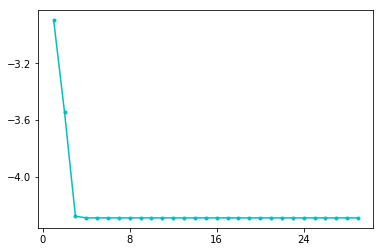

In [3]:
hmmar_trained_model_real, hmmar_info_dict_real = bnpy.run(dataobj,"HDPHMM","AutoRegGauss",'memoVB',
                  K=K,output_path="./results/",nLap=50, nTask=1, nBatch=1, convergeThr=0.0001,
                  gamma=gamma, sF=sF, ECovMat='eye', initname='randexamples')
plt.plot(
    hmmar_info_dict_real['lap_history'],
    hmmar_info_dict_real['loss_history'], 'c.-',
    label='hmm + ar gauss')
plt.show()

## Fin